# Pick And Place With Geometry

In [Exercise 3.10](https://manipulation.csail.mit.edu/pick.html#section11), [Exercise 3.14](https://manipulation.csail.mit.edu/pick.html#section11), [Exercise 4.6](https://manipulation.csail.mit.edu/pose.html#exercises),  we designed various trajectories for the robot arm to follow, created a `DifferentialIKSystem`, used both pseudoinverse and optimization-based controllers to move the robot arm and used ICP to register point-clouds for object meshes from the scene cameras. In this notebook, we will combine these tools together to build an entire pick and place system based on the previous exercises that pick up your initials.

*Learning Objectives:*
Build an end to end system that  
1. Sets up a scenario with arbitrary meshes
2. Uses scene cameras and ICP to register the geometry of the objects
3. Uses a Differential-IK controller to do pick and place.

*What You'll Build:* An end to end pick and place system, featuring your intiials from Notebook 2. 

*Reference:* [Mustard Bottle Pick and Place](https://deepnote.com/workspace/Manipulation-ac8201a1-470a-4c77-afd0-2cc45bc229ff/project/cc6340f5-374e-449a-a195-839a3cedec4a/notebook/pose-c5a585e1a5fe4ebc8bc362c2a101857d)

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import trimesh
from pydrake.all import (
    AddFrameTriadIllustration,
    BasicVector,
    Concatenate,
    Context,
    Diagram,
    DiagramBuilder,
    Integrator,
    JacobianWrtVariable,
    LeafSystem,
    MultibodyPlant,
    PiecewisePolynomial,
    PiecewisePose,
    PointCloud,
    Rgba,
    RigidTransform,
    RobotDiagram,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    Trajectory,
    TrajectorySource,
)

from manipulation import running_as_notebook
from manipulation.exercises.grader import Grader
from manipulation.icp import IterativeClosestPoint
from manipulation.letter_generation import create_sdf_asset_from_letter
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.station import (
    AddPointClouds,
    LoadScenario,
    MakeHardwareStation,
    RobotDiagram,
)
from manipulation.utils import RenderDiagram

/usr/local/lib/python3.12/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Meshcat Visualization

As always, we begin by starting Meshcat.

In [2]:
# Start meshcat for visualization
meshcat = StartMeshcat()
print("Click the link above to open Meshcat in your browser!")

INFO:drake:Meshcat listening for connections at http://localhost:7000


Click the link above to open Meshcat in your browser!


# Part 1: Setting Up the Scenario

In [Exercise 1.4](https://manipulation.csail.mit.edu/intro.html#section7) from chapter 1 you created a scenario file for custom objects and used the `MakeHardwareStation` function and `LoadScenario` functions to create a simulation with your initials.

In this section, we'll repeat that setup so we can get started with our simulation. Unlike in that notebook, however, this time we will also add a set of scene cameras so we can also sense object locations. We'll make use of the `LoadScenario` function which will abstract away setting up the systems for all the cameras and the driver logic. In this section, we'll add onto this and create a more complicated scenario using all of the different types of functionalities of a scenario:
* Directives for all the robot arms, tables, and cameras
* Model drivers for all the robot arms so they can actually be actuated
* Cameras with corresponding configs. 

Because our simulation now consists of a lot of moving parts including the directives for both the robot arms and cameras, we will modularize the components into two parts: the directives and drivers/cameras. Then, simply running `LoadScenario` to get a `Scenario` config object and then running `MakeHardwareStation` will generate all the necessary systems for all the cameras which will allow us to generate the necessary point cloud geometry. 

First, we generate the initials and table assets again. For simplicity, in this notebook we will ask that you only generate one of your initials. In order to use the depth camera sensors to get the point clouds, we need to make sure our meshes also have all the normal information added (in real life all of this information is just available in the scene but in simulation these are properties that must be made available). Fortunately, this can be done by simply adding the`include_normal=True` argument to the original `create_sdf_assets_from_letter` function. Let's do that below:

**YOUR TASK**: Regenerate the letters with normals, create a station with the robot, cameras, and depth sensors, and add the corresponding systems.

**Key Concepts**: Using directives to append scenarios and adding point clouds to the system with `AddPointClouds` and `DepthImageToPointClouds`.

In [3]:
# A note: as an additional argument add `include_normals=True` to the `create_sdf_asset_from_letter` function.
# We also recommend you use a slightly smaller `letter_height_meters=0.15` and a rather high friction coefficient
# (we use mu_static = 1.17, mu_dynamic = 1.0 - roughly equal to the friction of rubber on granite) to make the
# letters easier to pick up. We'll study more complicated grasping strategies in future notebooks, but this is not
# the priority of this chapter so we'll cheat.

output_dir = Path("assets/")

# TODO: replace ADD_YOUR_INITIAL_HERE with your initial.
your_initial = "F"

# TODO: generate the SDF file for your intial.
create_sdf_asset_from_letter(
    text=your_initial,
    font_name="DejaVu Sans",
    letter_height_meters=0.15,
    extrusion_depth_meters=0.04,
    output_dir=output_dir / f"{your_initial}_model",
    use_bbox_collision_geometry=True,
    mass=0.1,
    include_normals=True,
    mu_static=1.17,
    mu_dynamic=1.0,
)

PosixPath('assets/F_model/F.sdf')

In [4]:
# TODO: Paste your table_sdf = ... code from Exercise 1.4 here
table_sdf = """<?xml version="1.0"?>
<sdf version="1.7">
  <model name="table">
    <pose>0 0 0 0 0 0</pose>
    <link name="table_link">
      <inertial>
        <mass>20</mass>
        <inertia>
          <ixx>1.0</ixx>
          <ixy>0.0</ixy>
          <ixz>0.0</ixz>
          <iyy>1.0</iyy>
          <iyz>0.0</iyz>
          <izz>1.0</izz>
        </inertia>
      </inertial>
      <collision name="box_collision">
        <geometry>
          <box>
            <size>2 2 0.1</size>
          </box>
        </geometry>
      </collision>
      <visual name="box_visual">
        <geometry>
          <box>
            <size>2 2 0.1</size>
          </box>
        </geometry>
      </visual>
    </link>
  </model>
</sdf>
"""

# TODO: Write the table SDF to assets/table.sdf
os.makedirs("assets", exist_ok=True)
with open("assets/table.sdf", "w") as fout:
    fout.write(table_sdf)

We'll now create a scenario with a Kuka IIWA arm, a table, and your initials along with a set of scene cameras. Because our scenario is becoming quite big, we'll first split up the scenario directives. We'll then load the directives and include the scene cameras and the drivers later in the scenario. As a reference, look at this [example](https://github.com/RussTedrake/manipulation/blob/3b74947270c02c7202cc33197d1e41d2cf34dea0/manipulation/models/clutter.scenarios.yaml) scenario file for an example of how to do so.

Once we have the correct scenario file, we can simply run `LoadScenario` and this will generate all of the camera systems. Unlike in [Exercise 3.14](https://manipulation.csail.mit.edu/pick.html#section11), we recommend adding around 3 scene cameras (the default settings in the example should work), but feel free to play around with the exact geometry of the cameras. 

Also, play around a bit with the exact starting position (the `X_PC` of the `iiwa_link_0` relative to the world frame). Make it start in a reasonable position relative to the letters, although it doesn't have to be perfect as we use now use geometric sensing.

In [5]:
# Add the directives for the bimanual IIWA arms, table, and initials
def generate_bimanual_IIWA14_with_assets_directives_file() -> (
    tuple[Diagram, RobotDiagram]
):
    table_sdf = f"{Path.cwd()}/assets/table.sdf"
    letter_sdf = f"{Path.cwd()}/assets/{your_initial}_model/{your_initial}.sdf"

    directives_yaml = f"""directives:
- add_model:
    name: iiwa
    file: package://drake_models/iiwa_description/sdf/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [-1.57]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [ 1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0
    X_PC:
        translation: [0, -0.5, 0]
        rotation: !Rpy {{ deg: [0, 0, 180] }}
- add_model:
    name: wsg
    file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
- add_weld:
    parent: iiwa::iiwa_link_7
    child: wsg::body
    X_PC:
        translation: [0, 0, 0.09]
        rotation: !Rpy {{ deg: [90, 0, 90]}}
- add_model:
    name: table
    file: file://{table_sdf}
- add_weld:
    parent: world
    child: table::table_link
    X_PC:
        translation: [0.0, 0.0, -0.05]
        rotation: !Rpy {{ deg: [0, 0, -90] }}
- add_model:
    name: {your_initial}_letter
    file: file://{letter_sdf}
    default_free_body_pose:
        {your_initial}_body_link:
            translation: [-0.35, 0, 0]
            rotation: !Rpy {{ deg: [0, 0, 0] }}
"""
    os.makedirs("directives", exist_ok=True)

    with open(
        "directives/bimanual_IIWA14_with_table_and_initials_and_assets.dmd.yaml", "w"
    ) as f:
        f.write(directives_yaml)


generate_bimanual_IIWA14_with_assets_directives_file()

We'll now add the camera directives into a seperate directive and then append them into a single scenario.

In [6]:
def create_camera_directives() -> None:
    camera_directives_yaml = """
directives:
- add_frame:
    name: camera0_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [-120.0, 0.0, 180.0]}
        translation: [0, 0.8, 0.5]

- add_model:
    name: camera0
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera0_origin
    child: camera0::base

- add_frame:
    name: camera1_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [-125, 0.0, 90.0]}
        translation: [0.8, 0.1, 0.5]

- add_model:
    name: camera1
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera1_origin
    child: camera1::base

- add_frame:
    name: camera2_origin
    X_PF:
        base_frame: world
        rotation: !Rpy { deg: [-120.0, 0.0, -90.0]}
        translation: [-0.8, 0.1, 0.5]

- add_model:
    name: camera2
    file: package://manipulation/camera_box.sdf

- add_weld:
    parent: camera2_origin
    child: camera2::base
"""
    with open("directives/camera_directives.dmd.yaml", "w") as f:
        f.write(camera_directives_yaml)


create_camera_directives()

Next, we'll combine the directives, camera configs, and drivers into a single scenario file. Look back at the [clutter scenario](https://github.com/RussTedrake/manipulation/blob/3b74947270c02c7202cc33197d1e41d2cf34dea0/manipulation/models/clutter.scenarios.yaml) example to see how to do this.

In [ ]:
def create_bimanual_IIWA14_with_assets_and_cameras_scenario() -> None:
    # TODO: create a scenario yaml with the directives added with `add_directives`
    iiwa_table_assets_path = os.path.abspath("directives/bimanual_IIWA14_with_table_and_initials_and_assets.dmd.yaml")
    camera_directives_path = os.path.abspath("directives/camera_directives.dmd.yaml")

    scenario_yaml = f"""directives:
    - add_directives:
        file: file://{iiwa_table_assets_path}
    - add_directives:
        file: file://{camera_directives_path}

cameras:
    camera0:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera0::base
    camera1:
        name: camera1
        depth: True
        X_PB:
            base_frame: camera1::base
    camera2:
        name: camera2
        depth: True
        X_PB:
            base_frame: camera2::base

model_drivers:
    iiwa: !IiwaDriver
        control_mode: position_only
        hand_model_name: wsg
    wsg: !SchunkWsgDriver {{}}
"""

    os.makedirs("scenarios", exist_ok=True)
    with open(
        "scenarios/bimanual_IIWA14_with_table_and_initials_and_assets_and_cameras.scenario.yaml",
        "w",
    ) as f:
        f.write(scenario_yaml)

create_bimanual_IIWA14_with_assets_and_cameras_scenario()

Now that we have the scenario file, we'll load it up into a DiagramBuilder using `MakeHardwareStation`. In order to get the point clouds for the meshes we will need to add the neccesary systems to the diagram. As in [Exercise 4.9](https://manipulation.csail.mit.edu/pose.html#exercises), we make use of the `AddPointClouds`function in `manipulation.station` which under the hood adds a `DepthImageToPointCloud` system to each camera (and connects it to the corresponding ports) in order to extract the corresponding point clouds. We will then need to export the output ports for this system to the output of the diagram allowing for these point clouds to be accesed for when we do ICP later.

In [8]:
def create_bimanual_IIWA14_with_table_and_initials_and_assets_and_cameras() -> (
    tuple[DiagramBuilder, RobotDiagram]
):
    # TODO: Load the scenario created above into a Scenario object
    scenario = LoadScenario(filename="scenarios/bimanual_IIWA14_with_table_and_initials_and_assets_and_cameras.scenario.yaml")

    # TODO: Create HardwareStation with the scenario and meshcat
    station = MakeHardwareStation(scenario, meshcat)

    # TODO: Make a DiagramBuilder, add the station, and build the diagram
    builder = DiagramBuilder()
    builder.AddSystem(station)

    # TODO: Add the point clouds to the diagram with AddPointClouds
    point_clouds = AddPointClouds(scenario=scenario, builder=builder, station=station)
    print(f"{point_clouds=}")

    # TODO: export the point cloud outputs to the builder
    for camera_name, point_cloud_system in point_clouds.items():
        builder.ExportOutput(
            point_cloud_system.GetOutputPort("point_cloud"),
            f"{camera_name}_point_cloud"
        )

    # TODO: Return the builder AND the station (notice that here we will need both)
    return builder, station

Great! We now have a scenario with our robot, assets, and the cameras. Build them up and render a diagram fromo the builder below to check for any errors:

point_clouds={'camera0': <pydrake.perception.DepthImageToPointCloud object at 0x7efb918dc8f0>, 'camera1': <pydrake.perception.DepthImageToPointCloud object at 0x7efb91940d10>, 'camera2': <pydrake.perception.DepthImageToPointCloud object at 0x7efb91940fb0>}


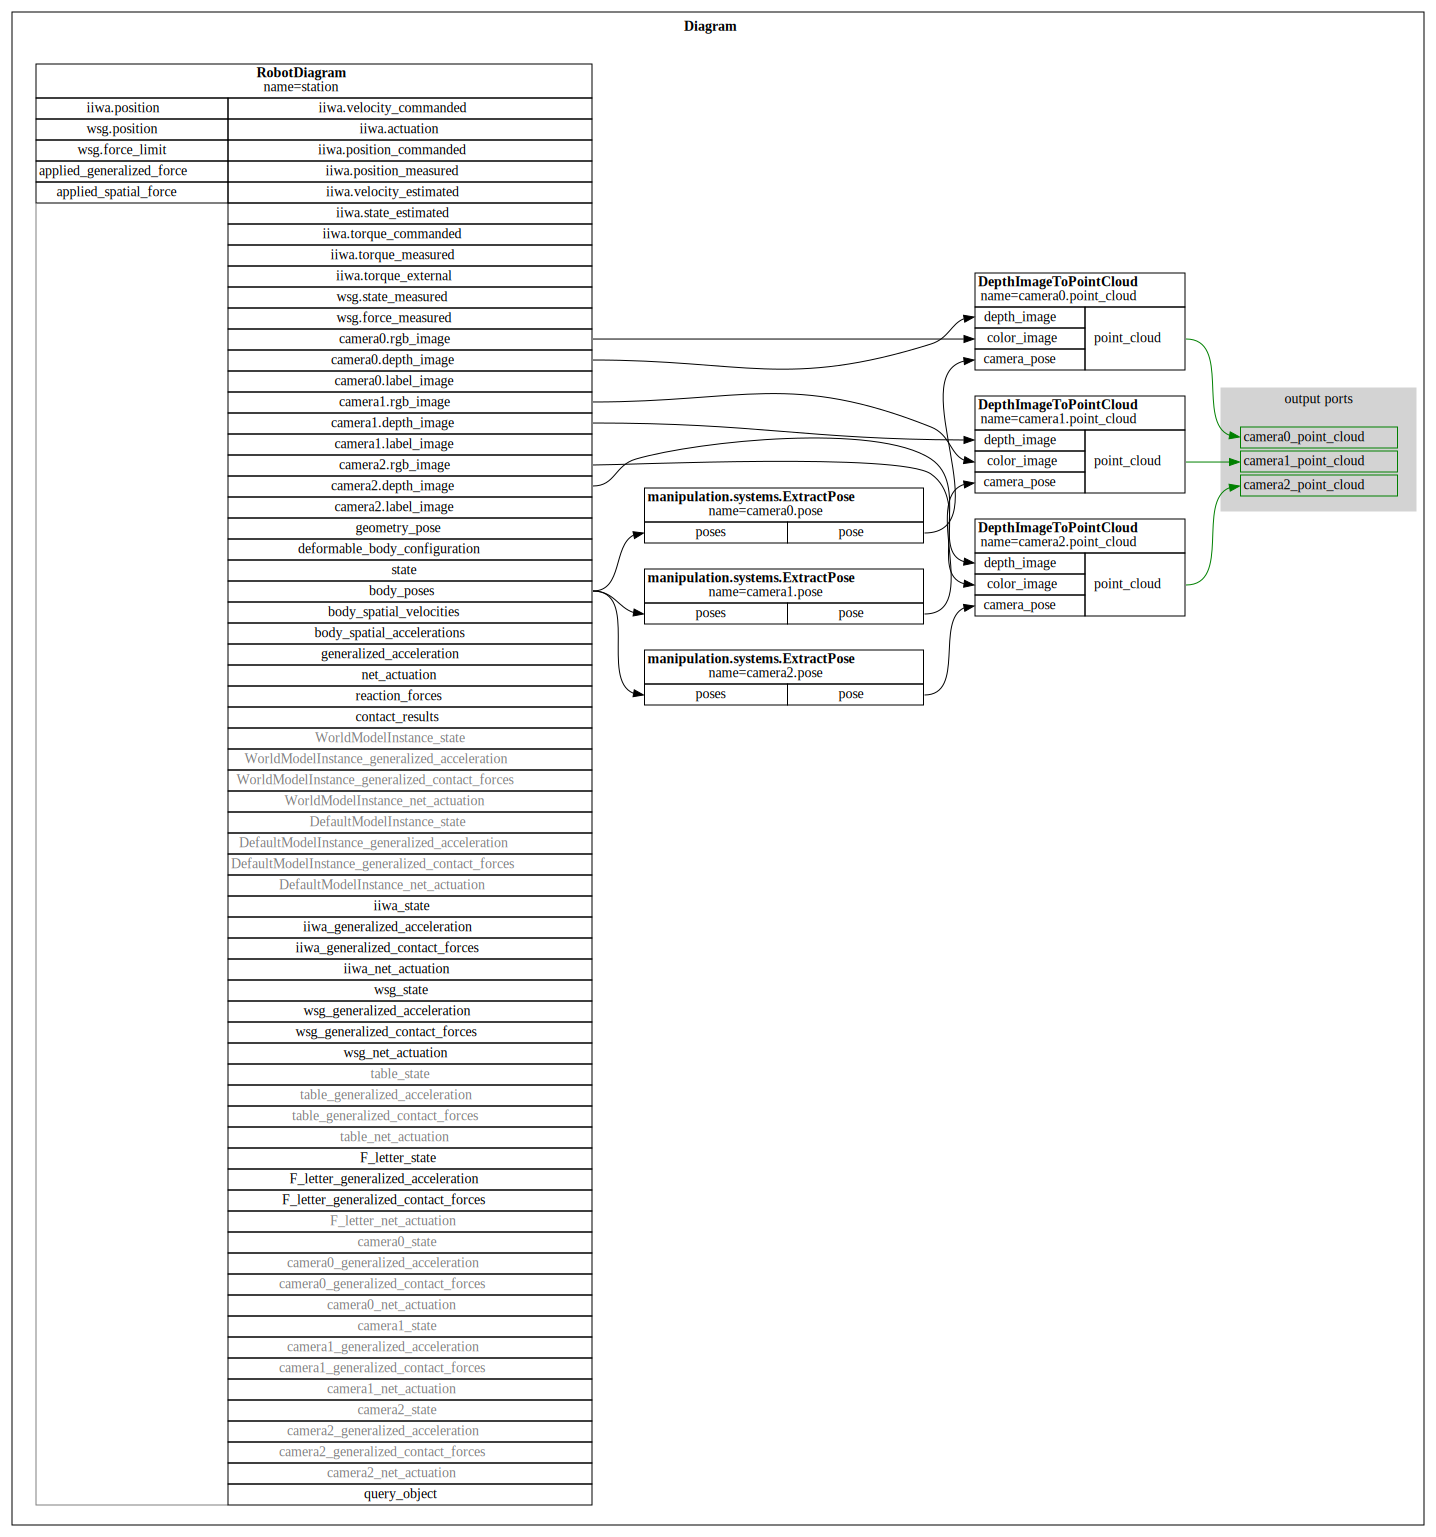

In [10]:
builder, station = (
    create_bimanual_IIWA14_with_table_and_initials_and_assets_and_cameras()
)

# in order to debug, we will build the diagram once here.
diagram = builder.Build()

# visualize the diagram
RenderDiagram(diagram, max_depth=1)

# publish the diagram with some default context
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)

## Getting the Point Cloud of the Model

Before running ICP, we need a point cloud of the *model* to compare against. To do this, we'll load into a `PointCloud` object the obj files corresponding to the letters. 

We'll make use of the [trimesh](https://trimesh.org/) library to do this. Because our obj file contains the full 3d geometry (rather than a set of points for a point cloud) we will need to load the obj file as a mesh and then sample points from it to get a point cloud. 

In [11]:
N_SAMPLE_POINTS = 1500

# TODO: load your intitials with trimesh.load(...) as a mesh.
# To do this, you should make sure to use the kwargs force="mesh".
# See the docs for more info at https://trimesh.org
initials_mesh = trimesh.load("assets/W_model/W.obj", force="mesh")

# TODO: sample N_SAMPLE_POINTS from the mesh and then turn those points into a numpy array (you might need to transpose)
# You should make use of the `sample` method of the mesh object.
initials_points = initials_mesh.sample(N_SAMPLE_POINTS).T
print(initials_points.shape)

# TODO: create a `PointCloud` object from the numpy array
initials_point_cloud = PointCloud(initials_points.shape[1])
initials_point_cloud.mutable_xyzs()[:] = initials_points

(3, 1500)


## Cropping Out the Point Clouds

Next, we'll get the camera point clouds. We'll start by cropping out the objects of interest within each camera. 

Start by visualizing the rgb and depth outputs of each of the rgbd sensors to make sure your camera is in the right position. If it's not, edit the camera rotation and/or translation so they roughly align with your initials. It doesn't have to be perfect as we'll segment out the objects later: the objects just have to lie in the frame. 

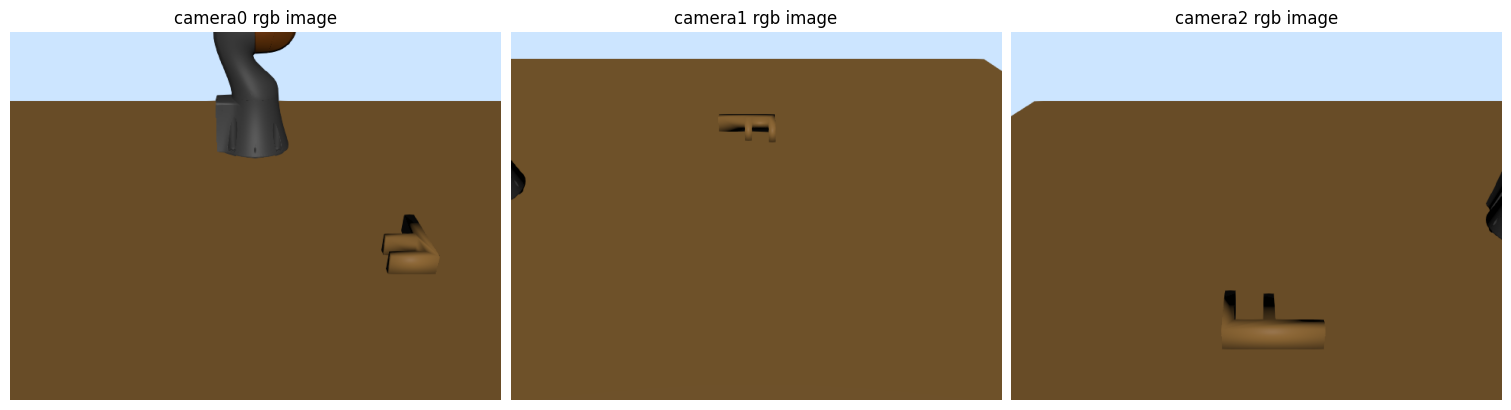

In [12]:
# run the following cell to visualize the rgb outputs of each of the cameras
cameras = ["camera0", "camera1", "camera2"]
station_context = diagram.GetSubsystemContext(station, context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.rgb_image").Eval(station_context)
    arr = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    im = ax.imshow(arr)
    ax.set_title(f"{cam} rgb image")
    ax.axis("off")

if running_as_notebook:
    plt.show()

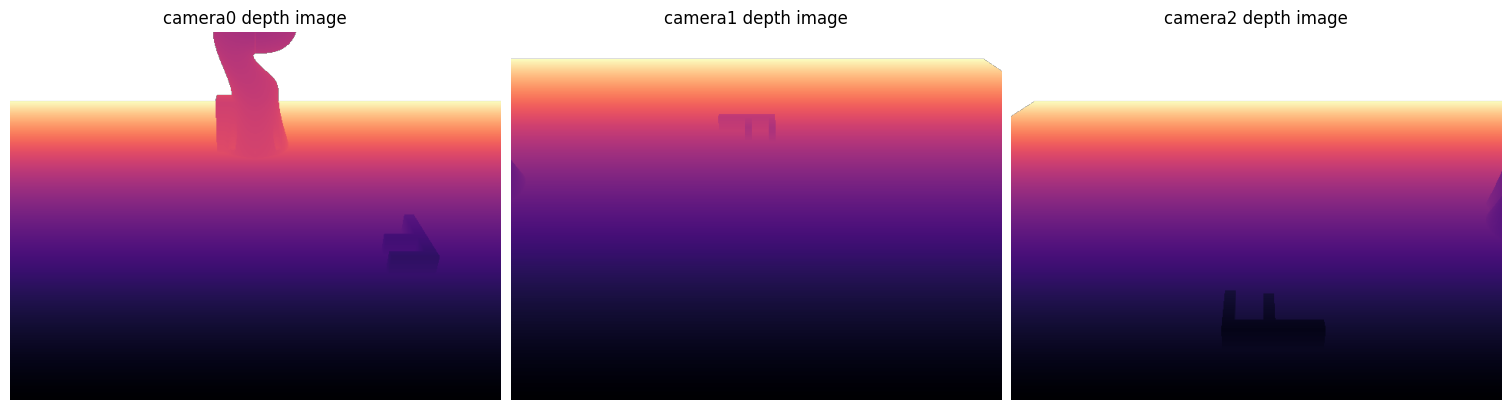

In [13]:
# run the following cell to visualize the depth outputs of each of the cameras
fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.depth_image").Eval(station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

if running_as_notebook:
    plt.show()

Next, we'll get the point clouds from each of the three cameras and simply crop out the desired regions (the regions that contain the letters) based on position. Here, we're going to cheat a little bit and use the reference positions of the letters based on the cheat ports in the system to save you some time, but in the real world you should either manually change the positions of the bounding boxes. We'll also remove the table point cloud as the point clouds from the table are not of interest. 

For more complicated scenarios, it might be helpful to use more interesting strategies for segmentation including color-based ones, outlier detection algorithms, end-to-end vision-based segmentation algorithms, and so forth. 

Use the [Mustard Bottle Point Cloud Processing](https://github.com/RussTedrake/manipulation/blob/c9f8d668de91241d170e3b6d692c4299e6f5e055/book/clutter/point_cloud_processing.ipynb#L75) and [Clutter Clearing](https://github.com/RussTedrake/manipulation/blob/c9f8d668de91241d170e3b6d692c4299e6f5e055/book/clutter/clutter_clearing.ipynb#L4) notebooks as an example.

In [14]:
# calculate the actual relative positions of each of the letters to use as a reference
# for cropping the point clouds.
plant = station.plant()
plant_context = diagram.GetSubsystemContext(plant, context)

world_frame = plant.world_frame()

model_letter = plant.GetModelInstanceByName(f"{your_initial}_letter")
frame_letter = plant.GetFrameByName(
    f"{your_initial}_body_link", model_instance=model_letter
)
X_PC_letter = plant.CalcRelativeTransform(plant_context, world_frame, frame_letter)

In [15]:
# TODO: get the point clouds from each of the cameras. For now, don't worry too much about
# removing the table points as we'll do that later.

# Get point clouds from each camera by evaluating the exported output ports
camera0_point_cloud_raw = diagram.GetOutputPort("camera0_point_cloud").Eval(context)
camera1_point_cloud_raw = diagram.GetOutputPort("camera1_point_cloud").Eval(context)
camera2_point_cloud_raw = diagram.GetOutputPort("camera2_point_cloud").Eval(context)

# TODO: crop out each of the letters from each of the cameras
# HINT: A simple way to do this is to use a simple Crop based on the X_PC_{letter} transforms given above.
#       Add a small offset based on the size of your letters to make the whole letter fit in the crop.
#       We add a visualization below to help you visualize the cropped point clouds.

# Define bounding box for cropping around the letter
# You'll need to adjust these values based on your letter size and position
letter_size_offset = 0.35  # Adjust this based on your letter size
letter_position = X_PC_letter.translation()

letter_lower = [
    letter_position[0] - letter_size_offset,  # x_min
    letter_position[1] - letter_size_offset,  # y_min
    letter_position[2] - 0.05                # z_min (slightly below letter)
]

letter_upper = [
    letter_position[0] + letter_size_offset,  # x_max
    letter_position[1] + letter_size_offset,  # y_max
    letter_position[2] + 0.1                  # z_max (above letter)
]

# Crop point clouds to extract only the letter regions
def crop_point_cloud_to_box(point_cloud, lower_bounds, upper_bounds):
    """Crop a point cloud to fit within the specified bounding box."""
    if point_cloud.size() == 0:
        return point_cloud
    
    # Get point cloud data
    points = point_cloud.xyzs()
    
    # Create mask for points within bounds
    mask = np.all([
        points[0, :] >= lower_bounds[0],  # x >= x_min
        points[0, :] <= upper_bounds[0],  # x <= x_max
        points[1, :] >= lower_bounds[1],  # y >= y_min
        points[1, :] <= upper_bounds[1],  # y <= y_max
        points[2, :] >= lower_bounds[2],  # z >= z_min
        points[2, :] <= upper_bounds[2],  # z <= z_max
    ], axis=0)
    
    # Extract points within bounds
    if np.any(mask):
        cropped_points = points[:, mask]
        # Create new point cloud with cropped points
        cropped_cloud = PointCloud(cropped_points.shape[1])
        cropped_cloud.mutable_xyzs()[:] = cropped_points
        return cropped_cloud
    else:
        # Return empty point cloud if no points in bounds
        return PointCloud(0)

# Apply cropping to each camera's point cloud
camera0_letter_point_cloud = crop_point_cloud_to_box(camera0_point_cloud_raw, letter_lower, letter_upper)
camera1_letter_point_cloud = crop_point_cloud_to_box(camera1_point_cloud_raw, letter_lower, letter_upper)
camera2_letter_point_cloud = crop_point_cloud_to_box(camera2_point_cloud_raw, letter_lower, letter_upper)

# This will visualize the bounding boxes for each of the letters in the point clouds
# Use it to adjust your bounding boxes to fit the letters.
if letter_lower is not None and letter_upper is not None:
    meshcat.SetLineSegments(
        "bounding_line",
        np.array(letter_lower).T,
        np.array(letter_upper).T,
        1.0,
        Rgba(0, 0, 0),
    )

# Concatenate the point clouds
point_clouds_numpy = np.concatenate([camera0_letter_point_cloud.xyzs(), camera1_letter_point_cloud.xyzs(), camera2_letter_point_cloud.xyzs()], axis=1)
letter_point_cloud = PointCloud(point_clouds_numpy.shape[1])
letter_point_cloud.mutable_xyzs()[:] = point_clouds_numpy

# Downsample the point clouds
# HINT: use the `VoxelizedDownSample` method for PointCloud
letter_point_cloud = letter_point_cloud.VoxelizedDownSample(0.01)

In [16]:
# TODO: implement a function that removes all points in the point cloud that lie below z=0.01
def cull_point_cloud_below_z(point_cloud: PointCloud, z: float = 0.01) -> PointCloud:
    cloud_numpy = point_cloud.xyzs()
    print(cloud_numpy.shape) # (3, n)
    cloud_mask = cloud_numpy[2, :] >= z
    
    new_cloud = PointCloud(cloud_mask.sum())
    new_cloud.mutable_xyzs()[:] = cloud_numpy[:, cloud_mask]
    return new_cloud

def remove_table_points(point_cloud: PointCloud) -> PointCloud:
    return cull_point_cloud_below_z(point_cloud, z=0.01)

# TODO: remove the table points from the concatenated point clouds
letter_point_cloud = remove_table_points(letter_point_cloud)

(3, 5153)


In [17]:
# visualize the concatenated point clouds
meshcat.SetObject(
    "letter_point_cloud", letter_point_cloud, point_size=0.01, rgba=Rgba(1, 0, 0, 0.6)
)

If everything is done correctly, you should be able to see point clouds for your intials that are created from your camera like below:

![ps3_p4](https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/geometry_pick_and_place_point_clouds.png)

NOTE: the things you should be visualizing should be `{letter}_source_cloud` NOT the `{letter}_model_source_cloud`s we created for reference for ICP.

## Registering Point Cloud Geometry with ICP

Now that we have the point clouds make use of the built in `IterativeClosestPoint` function to register the point cloud geometries. Use the [Pose Estimation ICP](https://github.com/RussTedrake/manipulation/blob/c9f8d668de91241d170e3b6d692c4299e6f5e055/book/pose/exercises/pose_estimation_icp.ipynb#L4) notebook as a reference. You should end up with a pose 

In [18]:
MAX_ITERATIONS = 25 if running_as_notebook else 2

# TODO: set initial guesses for each of the letters along with the maximum number of iterations
# These can be rough guesses as ICP will do the bulk of the work of aligning the point clouds.

# Use the current pose from the plant as initial guess
initial_guess = X_PC_letter

# TODO: convert both the model and generated point clouds to numpy arrays to pass into the ICP function

# Convert model point cloud (from mesh) to numpy array
model_points = initials_point_cloud.xyzs()  # Shape: (3, N)

# Convert observed point cloud (from cameras) to numpy array  
observed_points = letter_point_cloud.xyzs()  # Shape: (3, N)

# TODO: register the point clouds with the model point clouds using ICP for each of the letters

# Use ICP to register the observed points to the model points
letter_X_Ohat, chat = IterativeClosestPoint(
    model_points,                   # p_Om: Reference/target points (model)
    observed_points,                # p_Ws: Source points (observed from cameras)
    initial_guess,                  # X_Ohat: Initial transformation guess
    max_iterations=MAX_ITERATIONS   # Maximum number of iterations
)

In [19]:
# check the error in the registration for each of the letters below:
# if it has converged, all errors should be close to zero
np.set_printoptions(precision=3, suppress=True)
error_letter = letter_X_Ohat.inverse().multiply(X_PC_letter)

rpy = RollPitchYaw(error_letter.rotation()).vector()
xyz = error_letter.translation()
print(f"{your_initial}_letter error: rpy: {rpy}, xyz: {xyz}")

F_letter error: rpy: [-0.012  0.015  0.18 ], xyz: [ 0.023 -0.015 -0.   ]


# Part 3: Pick and Place with Registered Geometries

Phew! Now that we finally have all the geometry figured out, we can start doing pick and place with the initials. For this part, we'll mainly just be reusing the code from the previous pset with some minor edits. We'll be using a pseudoinverse controller for the pick and place, but for practice feel free to use something more complicated like an optimization-based controller which might come useful for more complicated scenarios.

We'll follow the same general pattern as [Exercise 3.14](https://manipulation.csail.mit.edu/pick.html#section11): this time, you will be tasked with getting at least one of your initials upright (so that the z axis of the object and the z axis of the world are parallel). This time we'll add a few more steps so the general trajectory will follow the pattern initial -> prepick -> pick -> preplace -> place -> postplace -> initial.

In [49]:
# TODO: modify the functions below to work with your letters. This will require quite a bit of trial and error.

def design_grasp_pose(X_WO: RigidTransform) -> tuple[RigidTransform, RigidTransform]:
    R_OG = (
        RotationMatrix.MakeZRotation(0.1) @
        RollPitchYaw(0, 0, np.pi).ToRotationMatrix()
        @ RollPitchYaw(-np.pi / 2, 0, 0).ToRotationMatrix()
    )
    p_OG = [0.07, 0.08, 0.12]
    X_OG = RigidTransform(R_OG, p_OG)
    X_WG = X_WO.multiply(X_OG)
    return X_OG, X_WG

def design_pregrasp_pose(
    X_WG: RigidTransform,
) -> tuple[RigidTransform, RigidTransform, RigidTransform]:
    X_GGApproach = RigidTransform([0.0, -0.2, 0.0])
    X_WGApproach = X_WG @ X_GGApproach
    return X_WGApproach

def design_pregoal_pose(
    X_WG: RigidTransform,
) -> tuple[RigidTransform, RigidTransform, RigidTransform]:
    X_GGApproach = RigidTransform([0.0, 0.0, -0.2])
    X_WGApproach = X_WG @ X_GGApproach
    return X_WGApproach


# The goal poses have been modified to include the third initial.
def design_goal_poses(
    X_WO: RigidTransform, X_OG: RigidTransform
) -> tuple[RigidTransform, RigidTransform, RigidTransform]:
    X_WOgoal = X_WO @ RigidTransform(
        R=RotationMatrix.MakeXRotation(np.pi / 2), p=np.array([-0.1, 0.2, 0.03])
    )
    X_WGgoal = X_WOgoal @ X_OG
    return X_WGgoal


def design_postgoal_pose(
    X_WG: RigidTransform,
) -> tuple[RigidTransform, RigidTransform, RigidTransform]:
    X_GGApproach = RigidTransform([0.0, 0.0, -0.2])
    X_WGApproach = X_WG @ X_GGApproach
    return X_WGApproach


def make_trajectory(
    X_Gs: list[RigidTransform], finger_values: np.ndarray, sample_times: list[float]
) -> tuple[Trajectory, PiecewisePolynomial]:
    robot_position_trajectory = PiecewisePose.MakeLinear(sample_times, X_Gs)
    robot_velocity_trajectory = robot_position_trajectory.MakeDerivative()
    traj_wsg_command = PiecewisePolynomial.FirstOrderHold(sample_times, finger_values)
    return robot_velocity_trajectory, traj_wsg_command

In [50]:
class PseudoInverseController(LeafSystem):
    def __init__(self, plant: MultibodyPlant):
        LeafSystem.__init__(self)
        self._plant = plant
        self._plant_context = plant.CreateDefaultContext()
        self._iiwa = plant.GetModelInstanceByName("iiwa")
        self._G = plant.GetBodyByName("body").body_frame()
        self._W = plant.world_frame()

        self.V_G_port = self.DeclareVectorInputPort("V_WG", 6)
        self.q_port = self.DeclareVectorInputPort("iiwa.position", 7)
        self.DeclareVectorOutputPort("iiwa.velocity", 7, self.CalcOutput)
        self.iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
        self.iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()

    def CalcOutput(self, context: Context, output: BasicVector):
        """
        fill in our code below.
        """
        # evaluate the V_G_port and q_port on the current context to get those values.
        V_G = self.V_G_port.Eval(context)
        q = self.q_port.Eval(context)

        # update the positions of the internal _plant_context according to `q`.
        # HINT: you can write to a plant context by calling `self._plant.SetPositions`
        # self._plant.SetPositions(self._plant_context, q)
        self._plant.SetPositions(self._plant_context, self._iiwa, q)

        # Compute the gripper jacobian
        # HINT: the jacobian is 6 x N, with N being the number of DOFs.
        # We only want the 6 x 7 submatrix corresponding to the IIWA
        J_G = self._plant.CalcJacobianSpatialVelocity(
            self._plant_context,
            JacobianWrtVariable.kQDot,
            self._G,
            [0, 0, 0],
            self._W,
            self._W  # or self._G? unclear
        )
        J_G = J_G[:, self.iiwa_start : self.iiwa_end + 1]

        # compute `v` by mapping the gripper velocity (from the V_G_port) to the joint space
        v = np.linalg.pinv(J_G) @ V_G
        output.SetFromVector(v)

Now that we have our controller along with the poses of each of the objects, we can finally finish our pick and place. This section will also mainly be copying over code from the previous pset:

In [51]:
# we will rebuild the diagram in order to add the controller and integrator systems we need.
builder, station = (
    create_bimanual_IIWA14_with_table_and_initials_and_assets_and_cameras()
)
plant = station.GetSubsystemByName("plant")

station_context = station.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(station_context)

# get initial poses of gripper and objects
X_WGinitial = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("body"))

# TODO: copy over the poses registered from ICP above
X_WOinitial = letter_X_Ohat

# Build trajectory keyframes
X_OG, X_WGpick = design_grasp_pose(X_WOinitial)
X_WGprepick = design_pregrasp_pose(X_WGpick)
X_WGgoal = design_goal_poses(X_WOinitial, X_OG)
X_WGpregoal = design_pregoal_pose(X_WGgoal)
X_WGpostgoal = design_postgoal_pose(X_WGgoal)

# constants for finger distances when the gripper is opened or closed
opened = 0.107
closed = 0.0

# list of keyframes, formatted as (gripper poses, finger states)
# for each object the robot starts in its default pose with its gripper open
# then it goes to the prepick pose, the pick pose, closes the gripper, and then goes
# to the place pose
keyframes = [
    ("X_WGinitial", X_WGinitial, opened),
    ("X_WGprepick", X_WGprepick, opened),
    ("X_WGpick", X_WGpick, opened),
    ("X_WGpick", X_WGpick, closed),
    ("X_WGpregoal", X_WGpregoal, closed),
    ("X_WGgoal", X_WGgoal, closed),
    ("X_WGgoal", X_WGgoal, opened),
    ("X_WGpostgoal", X_WGpostgoal, opened),
    ("X_WGinitial", X_WGinitial, opened),
]

# TODO: copy over your work from the previous pset
gripper_poses = [keyframe[1] for keyframe in keyframes]
finger_states = np.asarray([keyframe[2] for keyframe in keyframes]).reshape(1, -1)
sample_times = [3 * i for i in range(len(gripper_poses))]
traj_V_G, traj_wsg_command = make_trajectory(gripper_poses, finger_states, sample_times)

# V_G_source defines a trajectory over gripper velocities. Add it to the system.
V_G_source = builder.AddSystem(TrajectorySource(traj_V_G))
# Add the DiffIK controller we just defined to the system
controller = builder.AddSystem(PseudoInverseController(plant))
# The HardwareStation expects robot commands in terms of joint angles.
# We define the `integrator` system to map from joint_velocities to joint_angles.
integrator = builder.AddSystem(Integrator(7))
# wsg_source defines a trajectory of finger positions. Add it to the system.
wsg_source = builder.AddSystem(TrajectorySource(traj_wsg_command))

# TODO: connect the joint velocity source to the pseudoinverse controller
builder.Connect(V_G_source.get_output_port(), controller.V_G_port)

# TODO: connect the controller to integrator to get joint angle commands
builder.Connect(controller.get_output_port(), integrator.get_input_port())

# TODO: connect the joint angles computed by the integrateor to the iiwa.position port on the manipulation station
builder.Connect(integrator.get_output_port(), station.GetInputPort("iiwa.position"))

# TODO: connect the "iiwa.position_measured" port on the station back to the relevant input port on the controller
builder.Connect(station.GetOutputPort("iiwa.position_measured"), controller.GetInputPort("iiwa.position"))

# TODO: connect the wsg_source to the "wsg.position" input port of the station
builder.Connect(wsg_source.get_output_port(), station.GetInputPort("wsg.position"))

# visualize axes (useful for debugging)
scenegraph = station.GetSubsystemByName("scene_graph")
AddFrameTriadIllustration(
    scene_graph=scenegraph,
    body=plant.GetBodyByName(f"{your_initial}_body_link"),
    length=0.1,
)
AddFrameTriadIllustration(
    scene_graph=scenegraph, body=plant.GetBodyByName("body"), length=0.1
)

diagram = builder.Build()

point_clouds={'camera0': <pydrake.perception.DepthImageToPointCloud object at 0x7efb7445fa70>, 'camera1': <pydrake.perception.DepthImageToPointCloud object at 0x7efb5017d610>, 'camera2': <pydrake.perception.DepthImageToPointCloud object at 0x7efb5017d8b0>}


In [52]:
# Define the simulator
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
station_context = station.GetMyContextFromRoot(context)
integrator.set_integral_value(
    integrator.GetMyContextFromRoot(context),
    plant.GetPositions(
        plant.GetMyContextFromRoot(context),
        plant.GetModelInstanceByName("iiwa"),
    ),
)
diagram.ForcedPublish(context)
print(f"sanity check, simulation will run for {traj_V_G.end_time()} seconds")

# run simulation!
meshcat.StartRecording()
print(running_as_notebook)
if running_as_notebook:
    simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(traj_V_G.end_time() if running_as_notebook else 0.01)
meshcat.StopRecording()
meshcat.PublishRecording()

sanity check, simulation will run for 24.0 seconds
True


Congratulations! If you've done everything right you should now have a fully end to end system that finds the geometry of the objects, registers the geometries with ICP, and picks them and places them upright. The final result should look something like below: 

![pick-and-place-geometry-initials-upright](https://raw.githubusercontent.com/RussTedrake/manipulation/master/book/figures/exercises/pick-place-geometry-initials-upright.png)

As in the previous pset, if the robot fails to grasp a letter, or if the letter seems to be slipping inside the robot's fingers, experiment with different grasp poses. Different letters may call for higher or lower grasps. 


As a challenge (for fun), try adding all of your initials to the scene and getting them upright without knocking the other letters over! We'll cover ways to do this (motion planning) in later chapters.

**Once you have everything working, take a video and upload it to gradescope!**